In [1]:
import sys
import os
from tqdm import tqdm

import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
print("PyTorch version: ", torch.__version__)
print("GPU Detected:" ,torch.cuda.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0))

#defining a shortcut function for later:
# import os
# using_GPU = os.path.exists('/opt/bin/nvidia-smi')

using_GPU = torch.cuda.is_available()


PyTorch version:  1.9.0+cu102
GPU Detected: True
GPU Device Name: NVIDIA GeForce MX150


In [3]:
dataFolderPath = os.path.join("data2_1")

In [4]:
trainingPercentage = 0.7
testPercentage = 0.3

In [5]:
folders = ["data2_1", "data2_2", "data2_3"]
csvLists = [glob.glob(f"{folder}/*.csv") for folder in folders]

In [6]:
# print(csvLists)

In [6]:
overallTrain = []
overallTest = []
for csvList in csvLists:  
  train, test = train_test_split(csvList,
                                test_size=testPercentage,
                                train_size=trainingPercentage)
  overallTrain.extend(train)
  overallTest.extend(test)

## Define and fine tune the pre-process function
Our dataset contains many columns we don't need

In [7]:
def preProcessDataFrame(df: pd.DataFrame) -> pd.DataFrame:
  """
  Takes in a dataframe and returns another dataframe that contains only the data we want.
  Might wanna normalise the data as well
  Maybe fill the nulls with zeros or other appropriate values.
  """
  df_cp = df.copy()
  
#   df_cp.dropna(axis=0,
#                how='any', 
#                subset=["username", "tweet id"], 
#                inplace=True)
  
  df_cp = df_cp[["#followers",
                "#friends",
                "#retweets",
                "#favorites",
                "weekend",
                "entity_count",
                "hashtag_count",
                "mention_count",
                "url_count",
                "tlen",
                "ratio_fav_#followers",
                "time_importance",
                "sentiment_ppn",
                "sine_hour",
                "cosine_hour",
                "sine_day",
                "cosine_day",
                "sine_day_of_week",
                "cosine_day_of_week"
                ]]
  return df_cp


# sampleDf = pd.read_csv(overallTrain[0])
sampleDf = pd.read_csv(f"{dataFolderPath}/covid_data_1.csv")
# print(sampleDf.head())
print(sampleDf.info())
# [print(x) for x in sampleDf.columns] # show list of columns in sampleDf
print("\n====[AFTER PRE-PROCESSING]====\n")
# print(preProcessDataFrame(sampleDf.head()))
pp = preProcessDataFrame(sampleDf)
print(pp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            10000 non-null  int64  
 1   tweet_id              10000 non-null  int64  
 2   username              10000 non-null  object 
 3   timestamp             10000 non-null  object 
 4   #followers            10000 non-null  float64
 5   #friends              10000 non-null  int64  
 6   #retweets             10000 non-null  int64  
 7   #favorites            10000 non-null  int64  
 8   entities              10000 non-null  object 
 9   sentiment             10000 non-null  object 
 10  mentions              9984 non-null   object 
 11  hashtags              9998 non-null   object 
 12  urls                  10000 non-null  object 
 13  timeseg               10000 non-null  int64  
 14  date                  10000 non-null  object 
 15  weekend             

In [8]:
class TwitterDataset(Dataset):
  def __init__(self, filenames, preProcessFunc = None):
    # `filenames` is a list of strings the contains all file names.
    # `batch_size` is the determines the number of files that we want to read in a chunk.
        self.filenames = filenames
        self.preProcess = preProcessFunc
  def __len__(self):
        return len(self.filenames)
  def __getitem__(self, idx): #idx means index of the chunk.
    # In this method, we do all the preprocessing.
    # First read data from files in a chunk. Preprocess it. Extract labels. Then return data and labels.
        csvFile = self.filenames[idx]
        df = pd.read_csv(csvFile)
        if self.preProcess:
          df = self.preProcess(df)

        x_arr = torch.Tensor(df.drop(columns=['#retweets']).to_numpy().astype(float))
        y = torch.Tensor(df["#retweets"].to_numpy().astype(float))
        X = torch.squeeze( x_arr )
        if idx == self.__len__():  
          raise IndexError
        return X, y
  def sample_df(self, idx = 0):
    return self[idx]

In [9]:
train_loader = DataLoader(dataset = TwitterDataset(overallTrain, preProcessDataFrame),
                            batch_size = 1,
                            shuffle = True)
                            
test_loader = DataLoader(dataset = TwitterDataset(overallTest, preProcessDataFrame),
                            batch_size = 1,
                            shuffle = True)

# Build the network
Make sure this network takes in whatever input you give it and outputs a number. Alternative, if this is an immediate model, like the zero/more than zero retweets classifier, than train it and save the parameters externally. Then train the regressor in another copy of this script.

In [10]:
class myNeuralNetwork(nn.Module): # Please change the name to your own network
  def __init__(self, input_size):
    super(myNeuralNetwork, self).__init__()

    self.fc1 = nn.Linear(input_size, 2048)
    self.fc2 = nn.Linear(2048, 512)
    self.fc3 = nn.Linear(512, 128)
    self.fc4 = nn.Linear(128, 1)
    self.dropout = nn.Dropout(0.3)
    self.nonlinearity = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm1d(2048)
    self.batchnorm2 = nn.BatchNorm1d(512)
    self.batchnorm3 = nn.BatchNorm1d(128)

    pass

  def forward(self, x):

    x = self.dropout(F.relu(self.batchnorm1(self.fc1(x))))
    x = self.dropout(F.relu(self.batchnorm2(self.fc2(x))))
    x = self.dropout(F.relu(self.batchnorm3(self.fc3(x))))
    x = F.relu(self.fc4(x))

    return x

class myNeuralNetwork2(nn.Module): # Please change the name to your own network
  def __init__(self, input_size):
    super(myNeuralNetwork2, self).__init__()

    self.fc1 = nn.Linear(input_size, 256)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 64)
    self.fc4 = nn.Linear(64, 1)
    self.dropout = nn.Dropout(0.3)
    self.nonlinearity = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm1d(256)
    self.batchnorm2 = nn.BatchNorm1d(64)
    self.batchnorm3 = nn.BatchNorm1d(64)

    pass

  def forward(self, x):

    x = self.dropout(F.relu(self.batchnorm1(self.fc1(x))))
    x = self.dropout(F.relu(self.batchnorm2(self.fc2(x))))
    x = self.dropout(F.relu(self.batchnorm3(self.fc3(x))))
    x = F.relu(self.fc4(x))

    return x
  

  0%|          | 0/20 [00:00<?, ?it/s]

Model on GPU?:
True


  5%|▌         | 1/20 [09:37<3:03:00, 577.90s/it]

Epoch: 0, Loss: 1.589640736579895, 
MSELoss: 1.6068352460861206
Average MSELoss: 1.6948351251192328


 10%|█         | 2/20 [19:20<2:54:13, 580.74s/it]

Epoch: 1, Loss: 0.9835075736045837, 
MSELoss: 1.0482490062713623
Average MSELoss: 1.012096039125742


 15%|█▌        | 3/20 [30:02<2:52:30, 608.84s/it]

Epoch: 2, Loss: 0.9712141156196594, 
MSELoss: 0.8198702931404114
Average MSELoss: 0.8068716436378227


 20%|██        | 4/20 [40:50<2:46:27, 624.22s/it]

Epoch: 3, Loss: 0.8094204068183899, 
MSELoss: 0.6319640874862671
Average MSELoss: 0.7578526859441079


 25%|██▌       | 5/20 [51:27<2:37:09, 628.61s/it]

Epoch: 4, Loss: 0.9594272971153259, 
MSELoss: 0.6695811748504639
Average MSELoss: 0.6815577140524368


 30%|███       | 6/20 [1:01:49<2:26:13, 626.65s/it]

Epoch: 5, Loss: 1.0815564393997192, 
MSELoss: 1.3282554149627686
Average MSELoss: 1.3917348595690135


 35%|███▌      | 7/20 [1:11:22<2:11:55, 608.89s/it]

Epoch: 6, Loss: 1.2253559827804565, 
MSELoss: 1.8079677820205688
Average MSELoss: 1.807000598040494


 40%|████      | 8/20 [1:21:34<2:01:59, 609.92s/it]

Epoch: 7, Loss: 0.8903324007987976, 
MSELoss: 1.0347081422805786
Average MSELoss: 1.016537316574538


 45%|████▌     | 9/20 [1:32:16<1:53:39, 619.99s/it]

Epoch: 8, Loss: 0.7409958243370056, 
MSELoss: 0.5837755799293518
Average MSELoss: 0.644784072608002


 50%|█████     | 10/20 [1:43:18<1:45:29, 632.97s/it]

Epoch: 9, Loss: 0.710942268371582, 
MSELoss: 0.9658489227294922
Average MSELoss: 1.0002796039108401


 55%|█████▌    | 11/20 [1:54:16<1:36:04, 640.53s/it]

Epoch: 10, Loss: 0.7191508412361145, 
MSELoss: 2.1953585147857666
Average MSELoss: 2.0305670564824885


 60%|██████    | 12/20 [2:05:56<1:27:48, 658.62s/it]

Epoch: 11, Loss: 0.5541902184486389, 
MSELoss: 0.7491985559463501
Average MSELoss: 0.677582390052228


 65%|██████▌   | 13/20 [2:16:36<1:16:11, 653.05s/it]

Epoch: 12, Loss: 0.7657545804977417, 
MSELoss: 1.2567037343978882
Average MSELoss: 1.2031734237986162


 70%|███████   | 14/20 [2:26:42<1:03:53, 638.93s/it]

Epoch: 13, Loss: 0.6796009540557861, 
MSELoss: 2.499782085418701
Average MSELoss: 2.4924761204680137


 75%|███████▌  | 15/20 [2:36:24<51:48, 621.63s/it]  

Epoch: 14, Loss: 0.561079740524292, 
MSELoss: 0.9553400278091431
Average MSELoss: 0.9947749543781123


 80%|████████  | 16/20 [2:45:47<40:15, 603.99s/it]

Epoch: 15, Loss: 0.5194360017776489, 
MSELoss: 1.2343852519989014
Average MSELoss: 1.2240566159082837


 85%|████████▌ | 17/20 [2:55:02<29:28, 589.41s/it]

Epoch: 16, Loss: 0.659732460975647, 
MSELoss: 2.0369179248809814
Average MSELoss: 2.026334489672637


 90%|█████████ | 18/20 [3:05:03<19:45, 592.85s/it]

Epoch: 17, Loss: 0.5517520308494568, 
MSELoss: 2.04194974899292
Average MSELoss: 2.022690978523128


 95%|█████████▌| 19/20 [3:15:02<09:54, 594.78s/it]

Epoch: 18, Loss: 0.5416393876075745, 
MSELoss: 1.6786402463912964
Average MSELoss: 1.7333954625878452


100%|██████████| 20/20 [3:25:30<00:00, 616.50s/it]

Epoch: 19, Loss: 0.6629476547241211, 
MSELoss: 1.6586737632751465
Average MSELoss: 1.6563515639502155


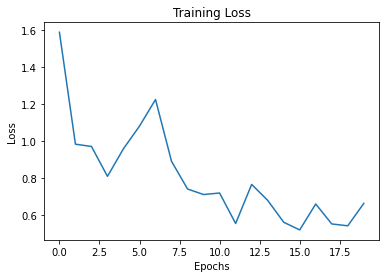

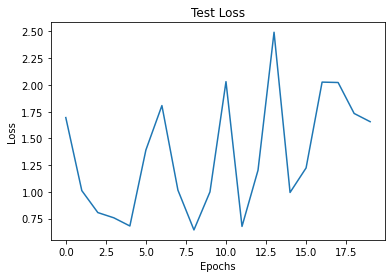

In [12]:
numEpochs = 20
lr_rate = 1e-5

input_size = 18

# b_size = 1000

model = myNeuralNetwork(input_size)
# model = myNeuralNetwork2(input_size)

loss_function = nn.MSELoss() # Change to BCELoss for classification problem

if using_GPU:
  model = model.cuda()

# Check if the Module is on GPU by checking if a parameter is on GPU
print("Model on GPU?:")
print(next(model.parameters()).is_cuda)

# optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)
# https://ruder.io/optimizing-gradient-descent/


train_loss_lst = []
test_loss_lst_1 = []
# prevMSELoss:float
def train():
    for m in tqdm(range(numEpochs)):
        model.train()
        for X, y in train_loader:

            X = torch.squeeze(X).cuda()
            y = y.T.cuda()

            optimizer.zero_grad() 
            y_hat = model(X)
            y_log = torch.log(y+1)
            loss = loss_function(y_hat, y_log) #calculate the loss
            loss.backward() #backprop
            optimizer.step() #does the update

        train_loss_lst.append(loss.cpu().data.numpy())

        model.eval()
        
        test_loss_lst = []
        for (n, (X, y)) in enumerate(test_loader):
            X = torch.squeeze(X).cuda()
            y = y.T.cuda()
            y_hat = model(X)
            y_log = torch.log(y+1)
            test_loss = loss_function(y_hat, y_log)
            test_loss_lst.append(test_loss.cpu().data.numpy())
            
        if m % 1 == 0:
            print ("Epoch: {0}, Loss: {1}, ".format(m, loss.cpu().data.numpy()))
            print(f"MSELoss: {test_loss}")
            avgMSELoss = sum(test_loss_lst)/len(test_loss_lst)
            test_loss_lst_1.append(avgMSELoss)
            print(f"Average MSELoss: {avgMSELoss}")
            # if(avgMSELoss > prevMSELoss):
            #     return
            # else:
            #     prevMSELoss = avgMSELoss
        
train()

plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_loss_lst)
plt.show()

plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(test_loss_lst_1)
plt.show()

In [13]:
now = datetime.now()

d4 = now.strftime("%Y%m%d_%H%M%S")

PATH = "model/model_{0}.pt".format(d4) #change this name to the name of your network

print(PATH)

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

PATH1 = "model_{0}.pt".format(d4)

pd.DataFrame(train_loss_lst).to_csv("model_loss_graph/train_loss_" + PATH1 +"_1" + '.csv')
pd.DataFrame(test_loss_lst_1).to_csv("model_loss_graph/test_loss_" + PATH1 +"_1"  + '.csv')

model/model_20210809_004242.pt


In [15]:
PATH = "model/model_20210803_103312.pt"

input_size = 18

# init empty model
model = myNeuralNetwork(input_size)

loss_function = nn.MSELoss() # Change to BCELoss for classification problem

# load checkpoint from saved path
checkpoint = torch.load(PATH)

# load model
model.load_state_dict(checkpoint['model_state_dict'])

if using_GPU:
  model = model.cuda()

model.eval()
test_loss_lst = []
y_e_list = []
y_list = []
for (n, (X, y)) in enumerate(test_loader):
    X = torch.squeeze(X).cuda()
    y = y.T.cuda()
    
    y_hat = model(X)
    y_e = torch.exp(y_hat) - 1

    y_log = torch.log(y+1)

    y_list.append(y.cpu().data.numpy())
    y_e_list.append(y_e.cpu().data.numpy())

    test_loss = loss_function(y_hat, y_log)
    test_loss_lst.append(test_loss.cpu().data.numpy())

print(f"MSELoss: {test_loss}")
avgMSELoss = sum(test_loss_lst)/len(test_loss_lst)
print(f"Average MSELoss: {avgMSELoss}")
# print(y_list)


In [ ]:
flatten_y = np.concatenate(y_list).ravel()
flatten_y_e = np.concatenate(y_e_list).ravel()

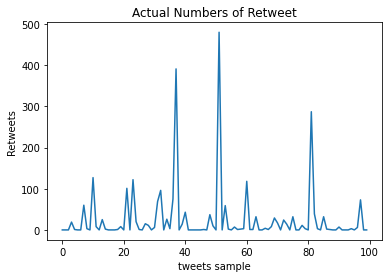

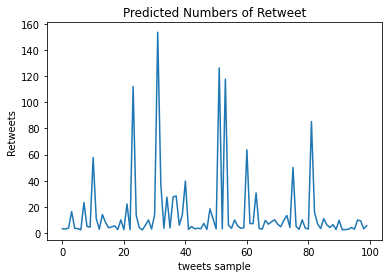

In [ ]:
i = np.random.randint(100)

plt.title("Actual Numbers of Retweet")
plt.xlabel("tweets sample")
plt.ylabel("Retweets")
plt.plot(flatten_y[i:i+100], label = "Actual")
plt.show()

plt.title("Predicted Numbers of Retweet")
plt.xlabel("tweets sample")
plt.ylabel("Retweets")
plt.plot(flatten_y_e[i:i+100] , label = "predicted")
plt.show()

In [ ]:
df_y = pd.DataFrame(flatten_y_e).astype(int)
print(df_y)

          0
0        19
1         4
2         2
3         3
4         4
...      ..
6034593  21
6034594   7
6034595   7
6034596   2
6034597   9

[6034598 rows x 1 columns]
